In [60]:
!pip3 install torch torchvision torchaudio
!pip install matplotlib

In [61]:
# Import the libraries we need for this lab

# Allows us to use arrays to manipulate and store data
import numpy as np
# Used to graph data and loss curves
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# PyTorch Library
import torch
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader
# PyTorch Neural Network
import torch.nn as nn

<p>The class plot_error_surfaces is just to help you visualize the data space and the parameter space during training and has nothing to do with Pytorch.</p>

In [62]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):

    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()

     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)

    # Plot diagram
    def final_plot(self):
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')

# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):

    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

In [63]:
# Setting the seed will allow us to control randomness and give us reproducibility
torch.manual_seed(0)

<h3>Load data</h3>

In [64]:
# Create the custom Data class which inherits Dataset
class Data(Dataset):

    # Constructor
    def __init__(self):
        # Create X values from -1 to 1 with step .1
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        # Create Y values all set to 0
        self.y = torch.zeros(self.x.shape[0], 1)
        # Set the X values above 0.2 to 1
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]

    # Getter that returns the data at the given index
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get length of the dataset
    def __len__(self):
        return self.len

In [65]:
# Create Data object
data_set = Data()

In [66]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [67]:
data_set.y # y values of the dataset which corresponds to the class of the x value

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [68]:
len(data_set)

20

In [69]:
x,y = data_set[0]
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


<p>We can see we can separate the one-dimensional dataset into two classes:</p>

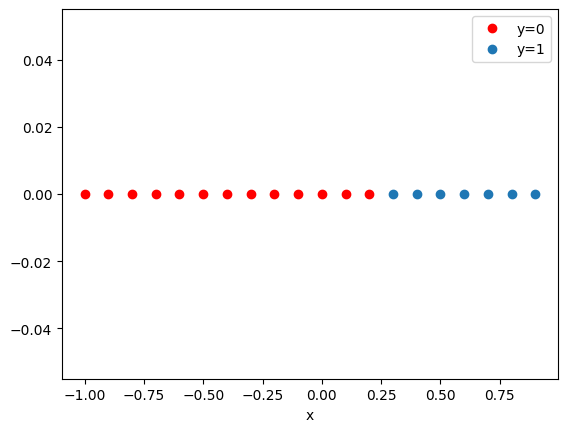

In [70]:
plt.plot(data_set.x[data_set.y==0], data_set.y[data_set.y==0], 'ro', label="y=0")
plt.plot(data_set.x[data_set.y==1], data_set.y[data_set.y==1]-1, 'o', label="y=1")
plt.xlabel('x')
plt.legend()

<H3>Create the model and total loss function cost

For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.

We will create a custom class that defines the architecture of Logistic Regression using PyTorch. Logistic Regression has a single layer where the input is the number of features an X value of the dataset has (dimension of X) and there is a single output. The output of the layer is put into a sigmoid function which is a function between 0 and 1. The larger the output of the layer the closer it is to 1 and the smaller the output is the closer it is to 0. The sigmoid function will allow us to turn this output into a classification problem. If the output value is closer to 1 it is one class if it is closer to 0 it is in another.


In [71]:
# Create logistic_regression class that inherits nn.Module which is the base class for all neural networks
class logistic_regression(nn.Module):

    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        # Single layer of Logistic Regression with number of inputs being n_inputs and there being 1 output
        self.linear = nn.Linear(n_inputs, 1)

    # Prediction
    def forward(self, x):
        # Using the input x value puts it through the single layer defined above then puts the output through the sigmoid function and returns the result
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [72]:
x,y = data_set[0]
len(x)

1

In [73]:
# Create the logistic_regression result

model = logistic_regression(1)

In [74]:
x = torch.tensor([-1.0])

sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [75]:
x,y = data_set[2]

sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward0>)

Create a plot_error_surfaces object to visualize the data space and the learnable parameters space during training:

We can see on the Loss Surface graph, the loss value varying across w and b values with yellow being high loss and dark blue being low loss which is what we want

On the Loss Surface Contour graph we can see a top-down view of the Loss Surface graph

<Figure size 640x480 with 0 Axes>

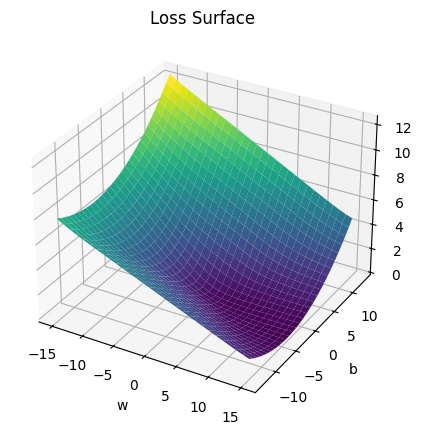

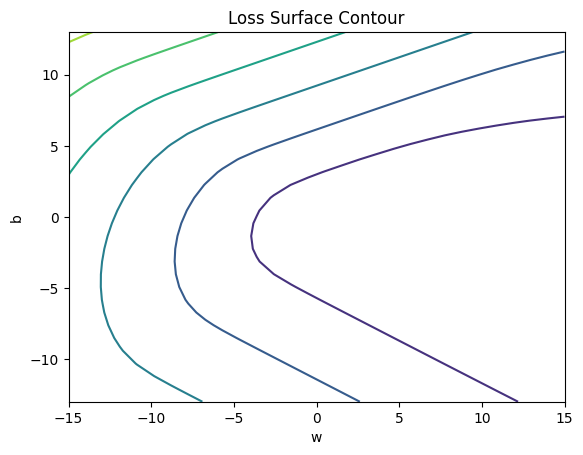

In [76]:
# Create the plot_error_surfaces object

# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

In [77]:
#We define a criterion using Binary Cross Entropy Loss.
#This will measure the difference/loss between the prediction and actual value.
criterion = nn.BCELoss()

In [78]:
x, y = data_set[0]
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


In [79]:
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [80]:
loss = criterion(sigma, y)
loss

tensor(1.0016, grad_fn=<BinaryCrossEntropyBackward0>)

<h3>Setting the batch size using a data loader</h3>

In [81]:
batch_size=10
trainloader = DataLoader(dataset = data_set, batch_size = 10)
dataset_iter = iter(trainloader)
X,y=next(dataset_iter )

In [82]:
X

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

<h3>Setting the learning rate</h3>
<p>We can set the learning rate by setting it as a parameter in the optimizer along with the parameters of the logistic regression model we are training. The job of the optimizer, torch.optim.SGD, is to use the loss generated by the criterion to update the model parameters according to the learning rate. SGD stands for Stochastic Gradient Descent which typically means that the batch size is set to 1, but the data loader we set up above has turned this into Mini-Batch Gradient Descent.</p>

In [83]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

<h3>Train the Model via Mini-batch gradient descent</h3>
<p>We are going to train the model using various Batch Sizes and Learning Rates.</p>

<Figure size 640x480 with 0 Axes>

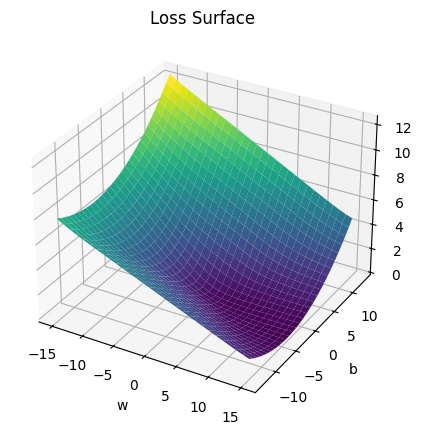

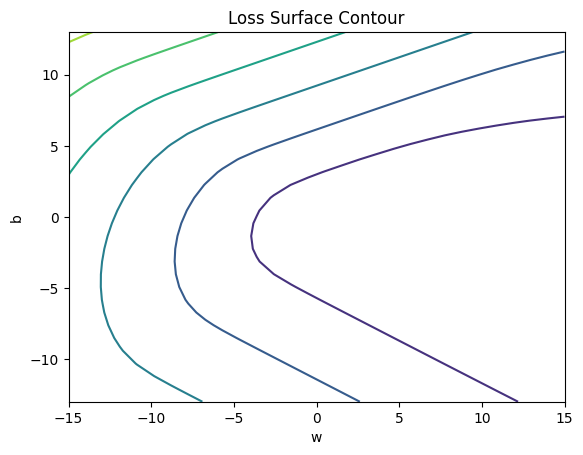

In [84]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

<h4>Train the Model</h4>

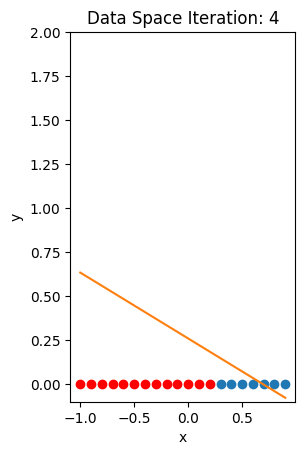

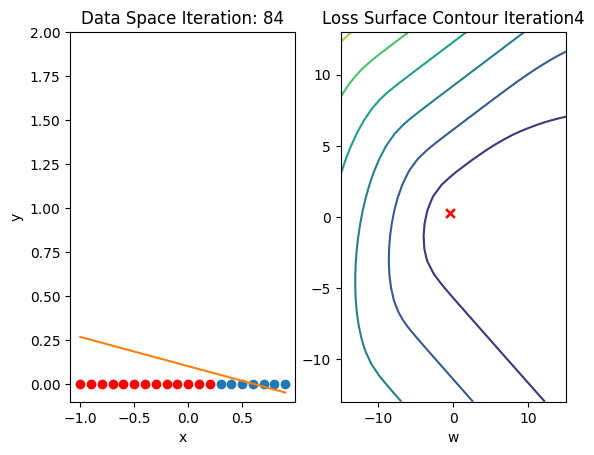

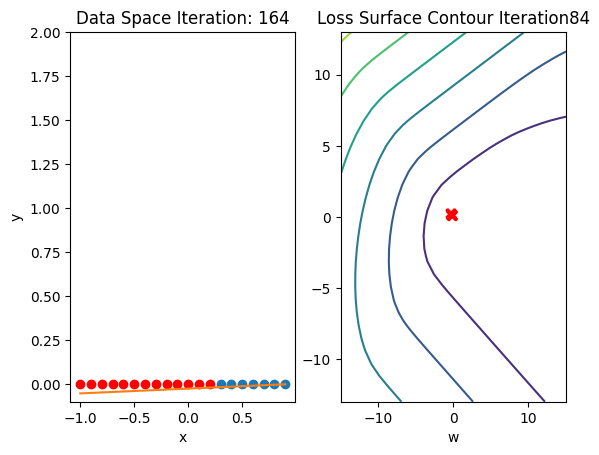

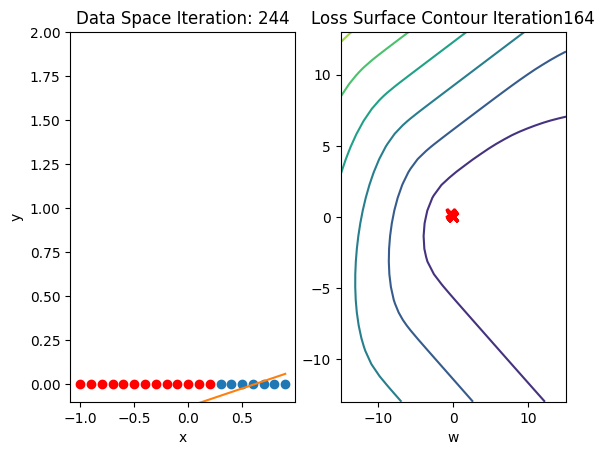

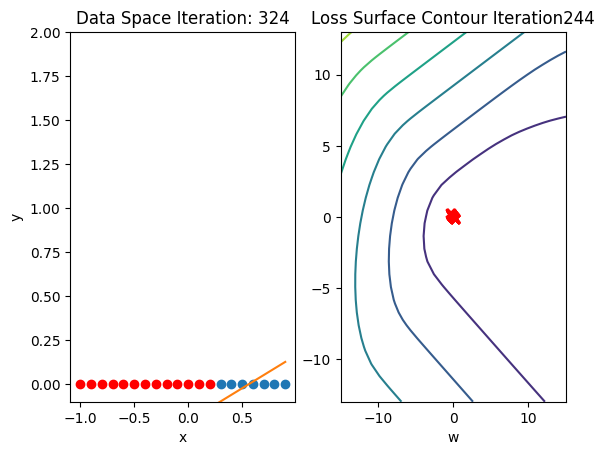

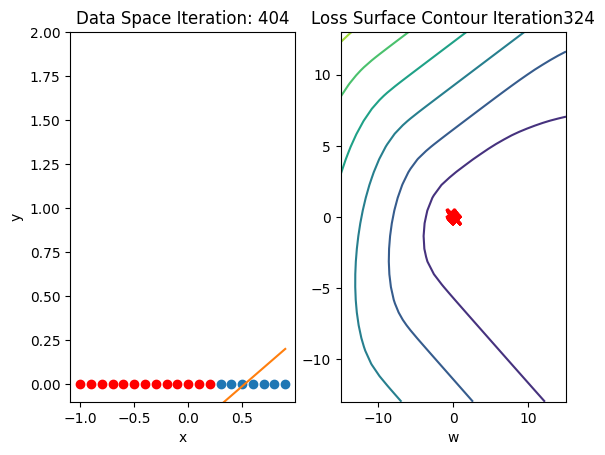

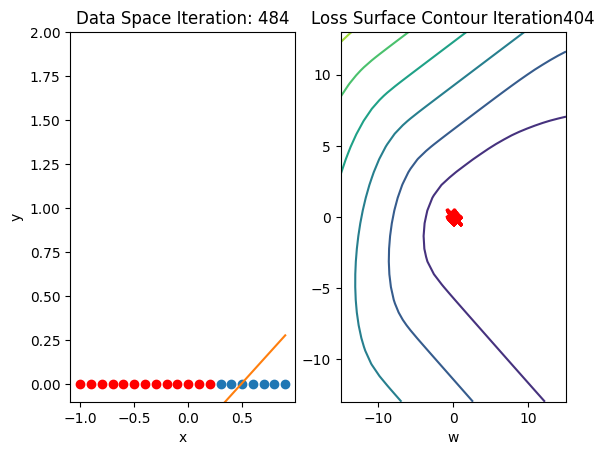

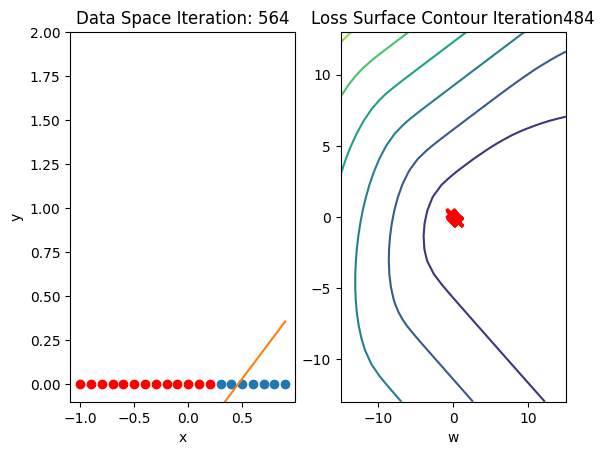

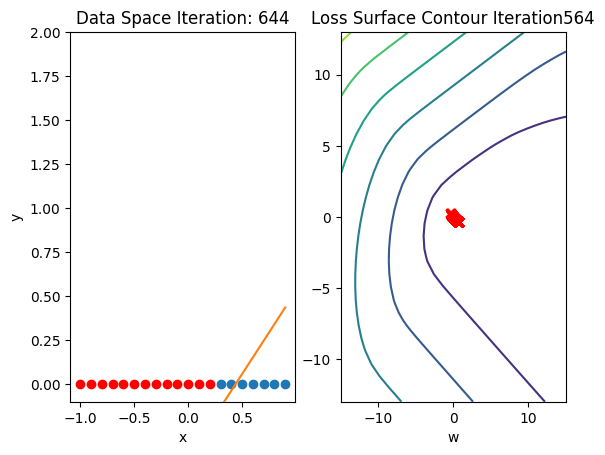

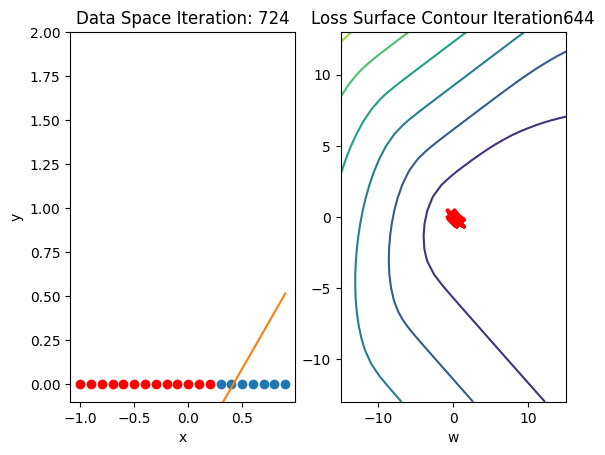

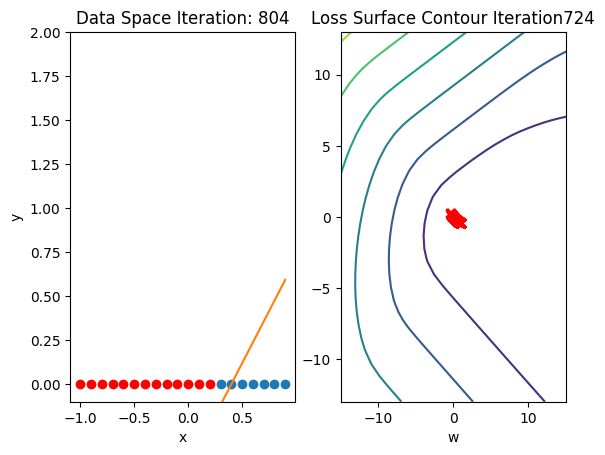

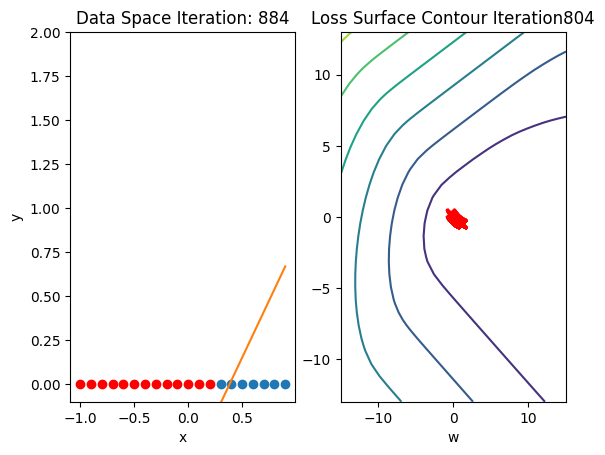

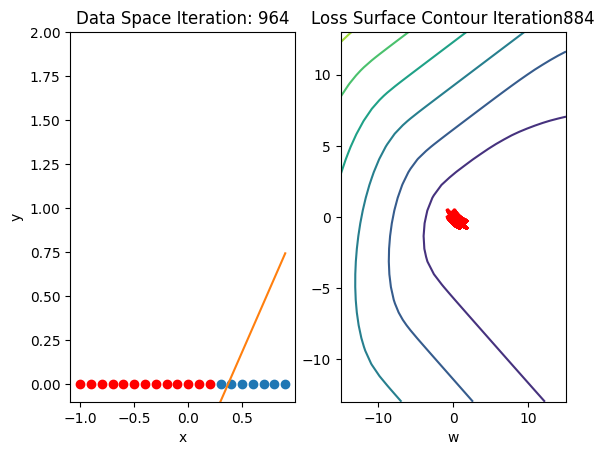

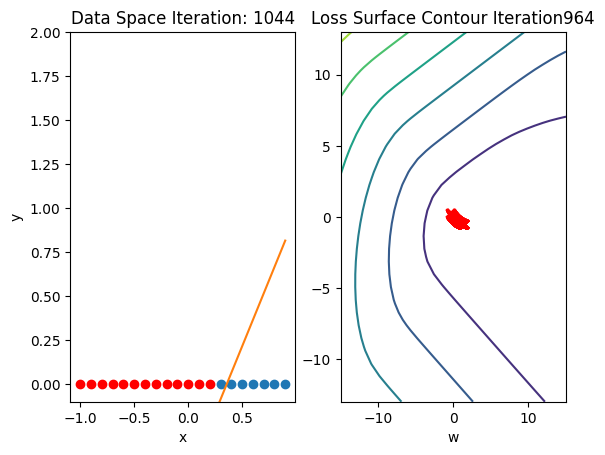

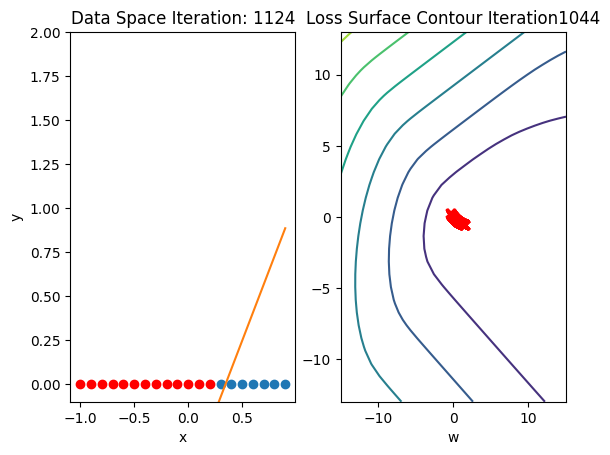

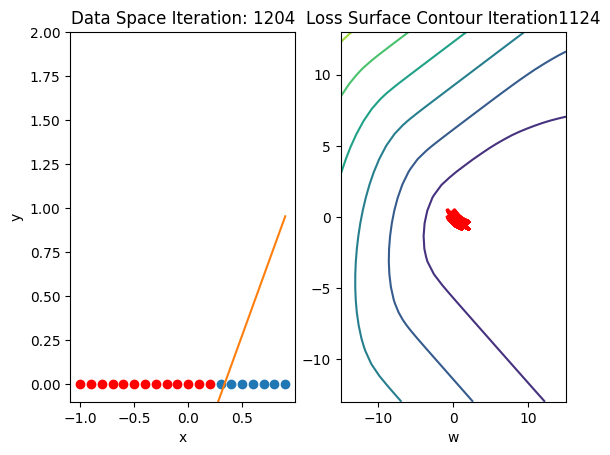

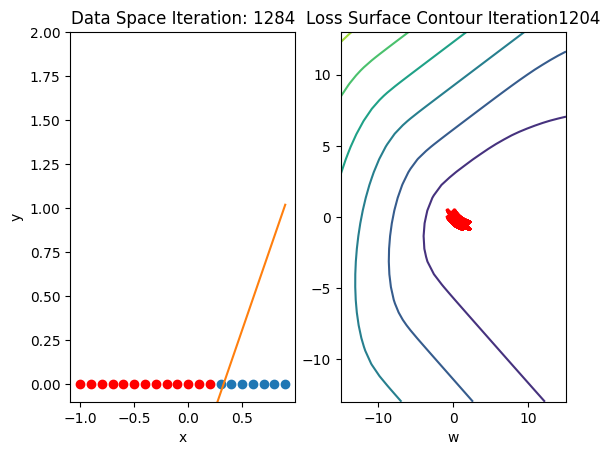

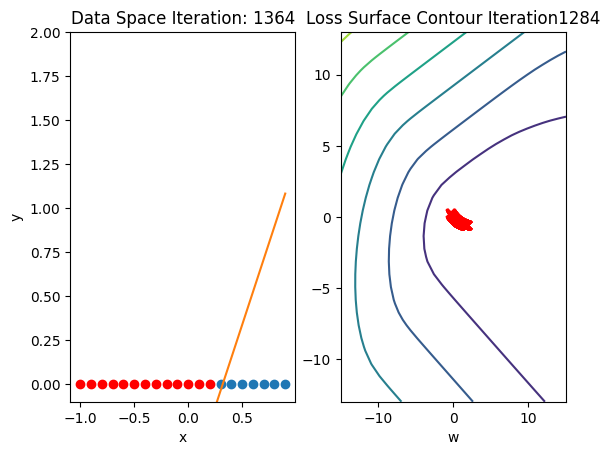

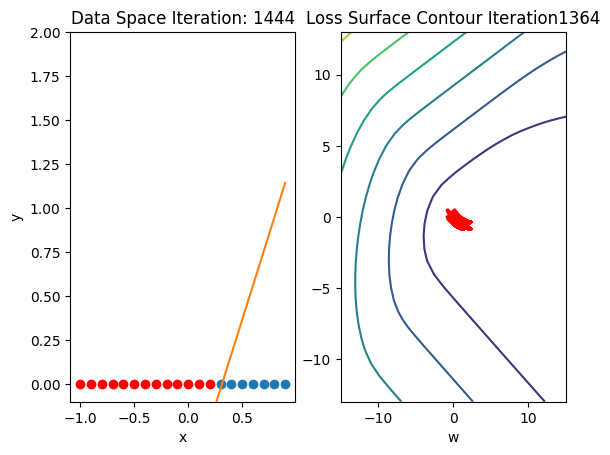

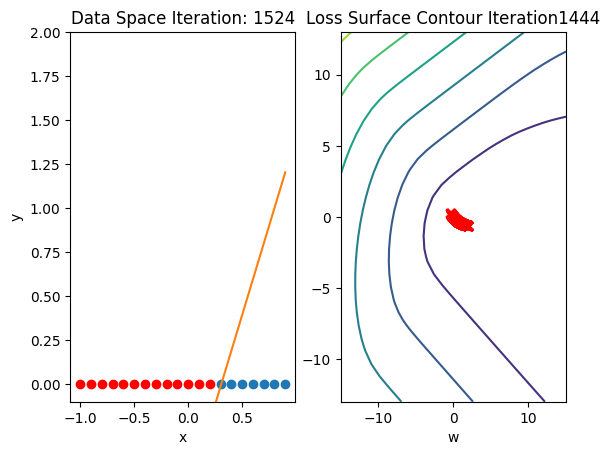

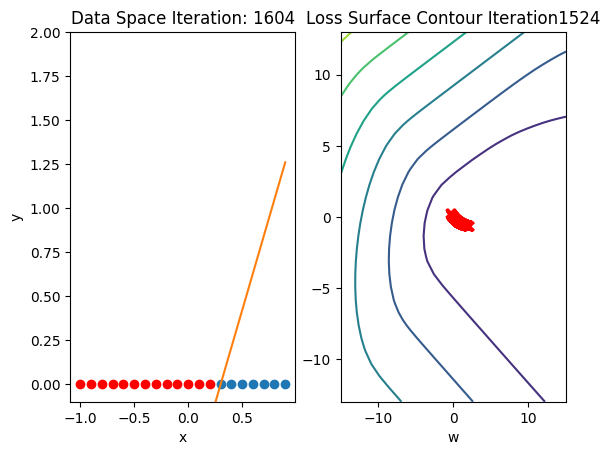

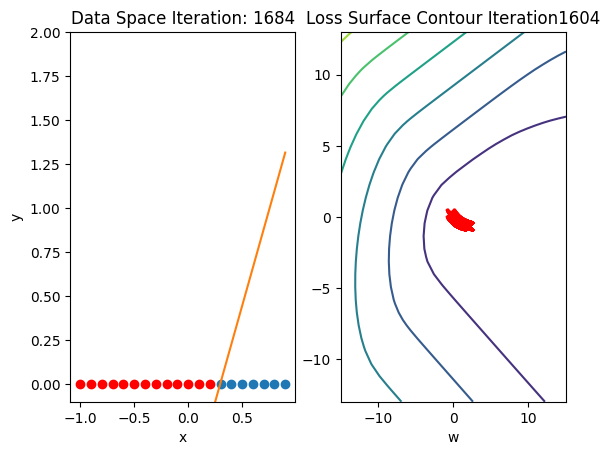

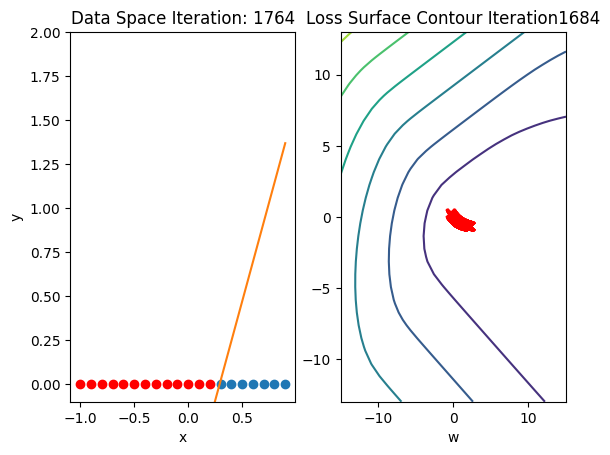

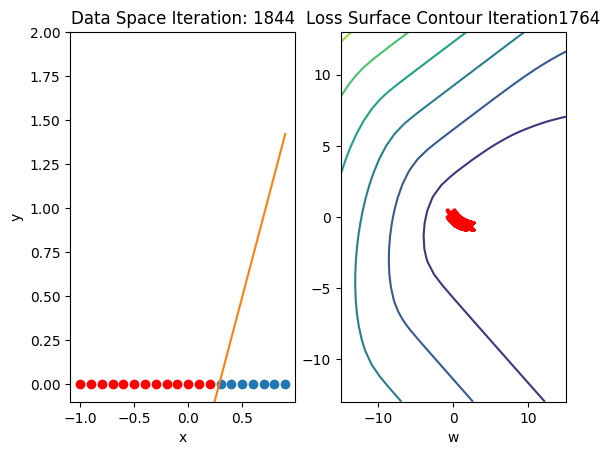

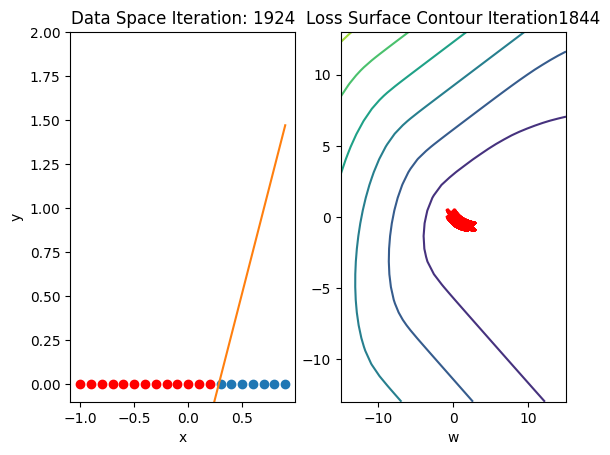

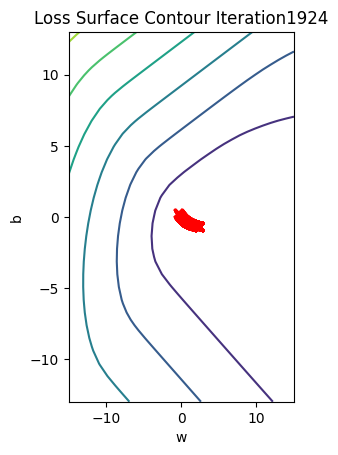

In [85]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 5
trainloader = DataLoader(dataset = data_set, batch_size = 5)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=500
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [86]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.4503]) b =  tensor(-0.6884)


In [87]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

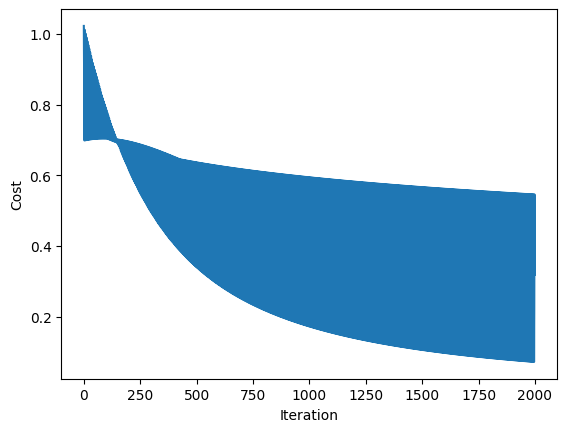

In [88]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())

plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")


<Figure size 640x480 with 0 Axes>

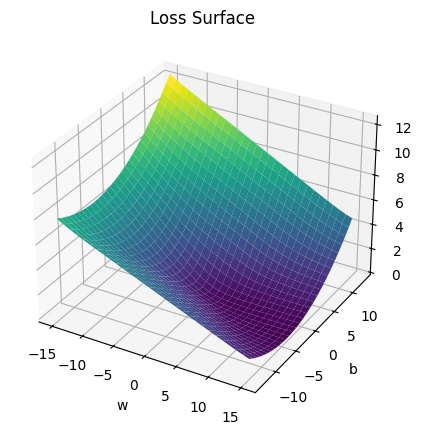

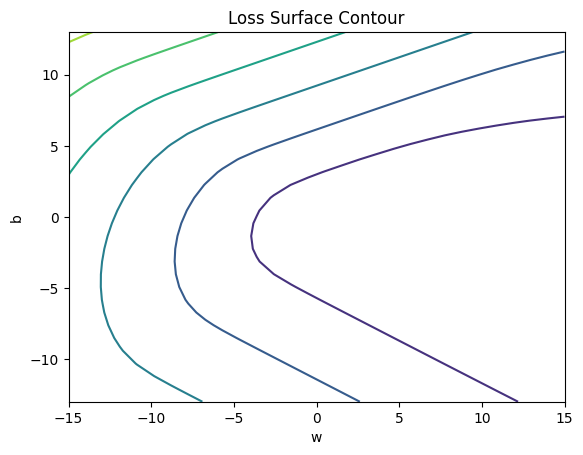

In [89]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

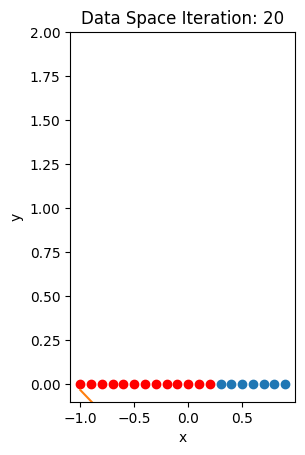

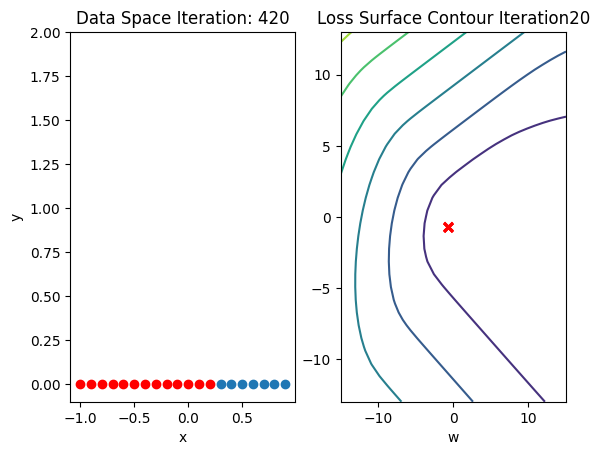

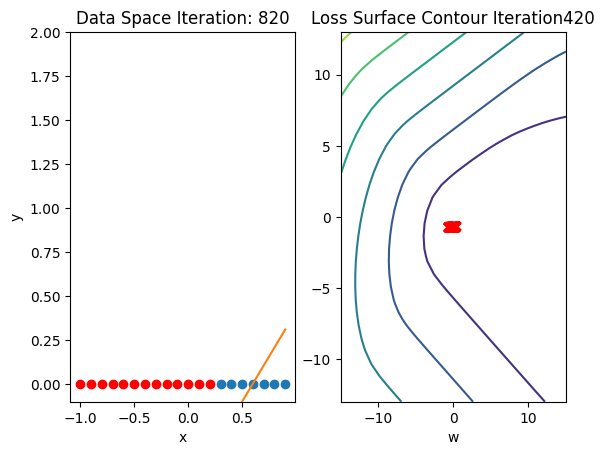

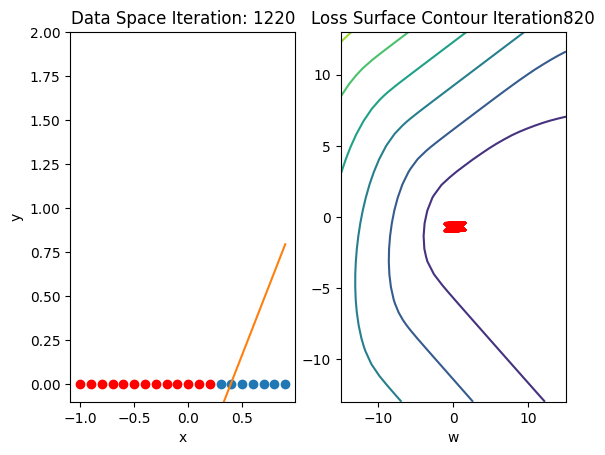

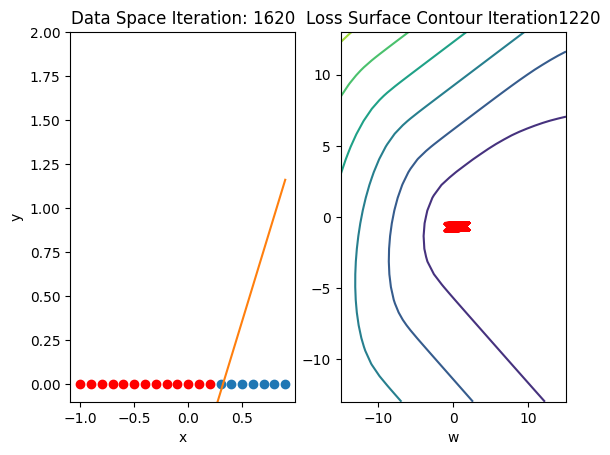

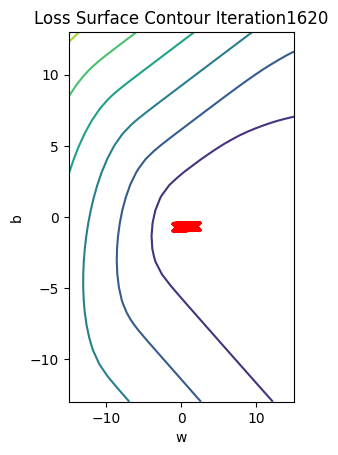

In [90]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [91]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.3581]) b =  tensor(-0.6842)


In [92]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

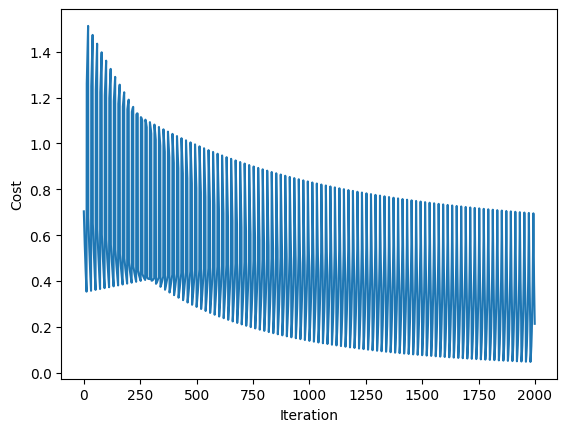

In [93]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())


plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")


<Figure size 640x480 with 0 Axes>

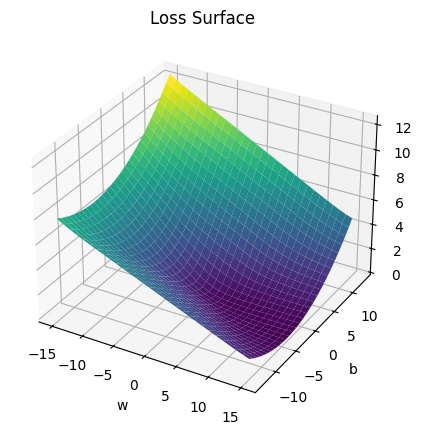

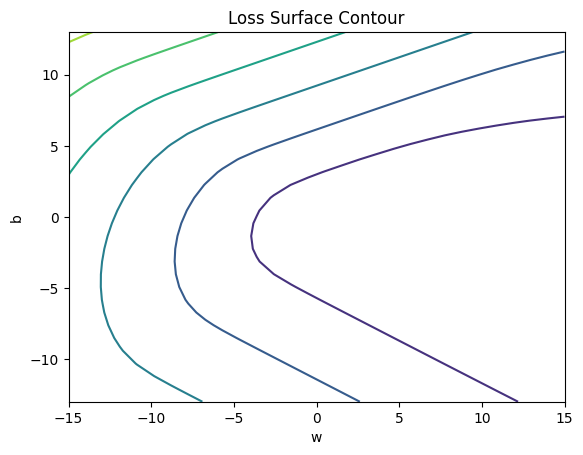

In [94]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

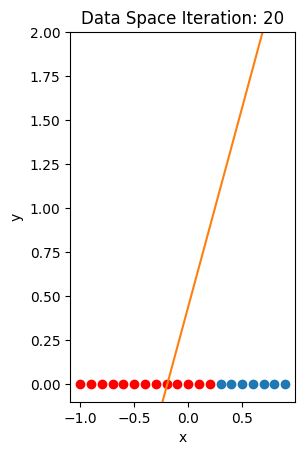

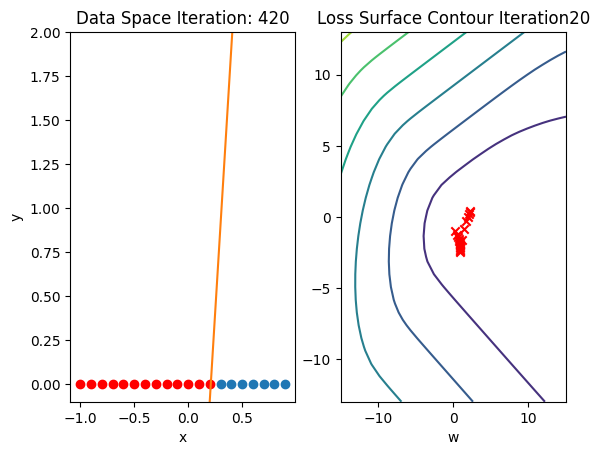

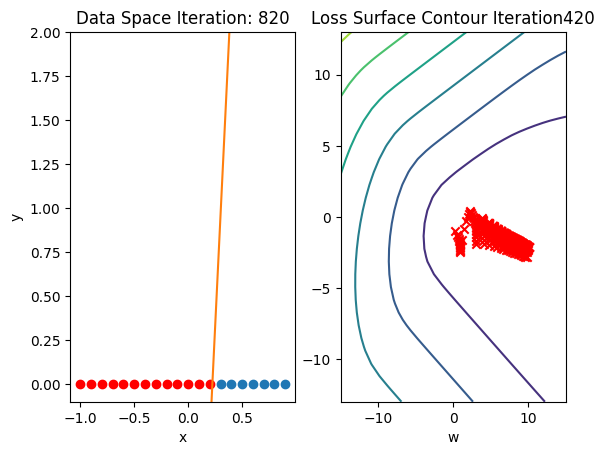

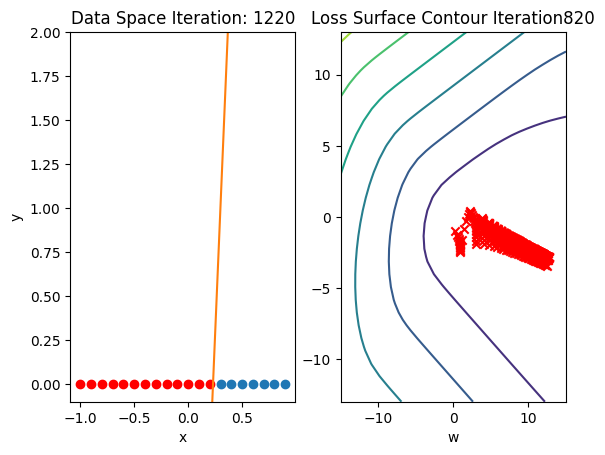

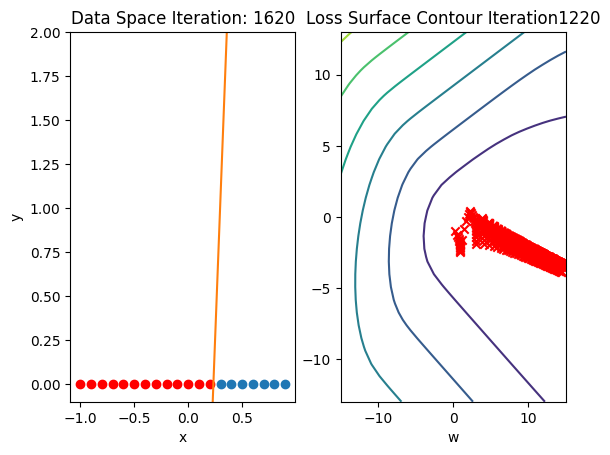

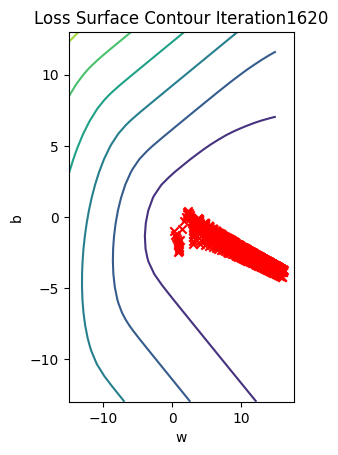

In [95]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion that will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [96]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([17.2987]) b =  tensor(-4.0843)


In [97]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


Text(0, 0.5, 'Cost')

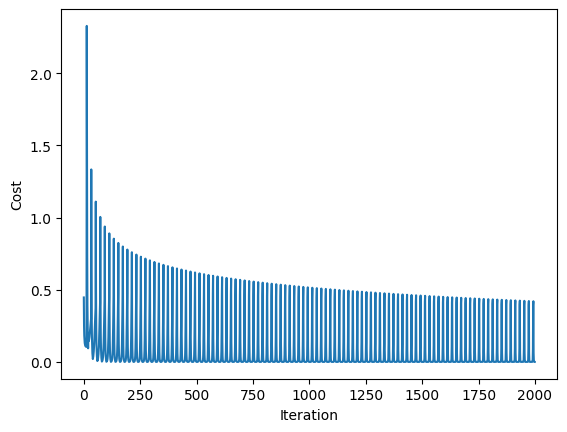

In [98]:
LOSS_BGD1=[]
for i in loss_values:
    LOSS_BGD1.append(i.item())


plt.plot(LOSS_BGD1)
plt.xlabel("Iteration")
plt.ylabel("Cost")


<Figure size 640x480 with 0 Axes>

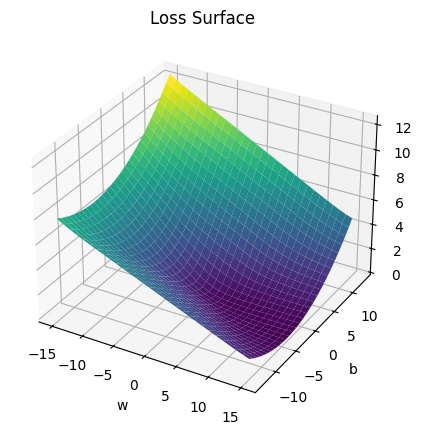

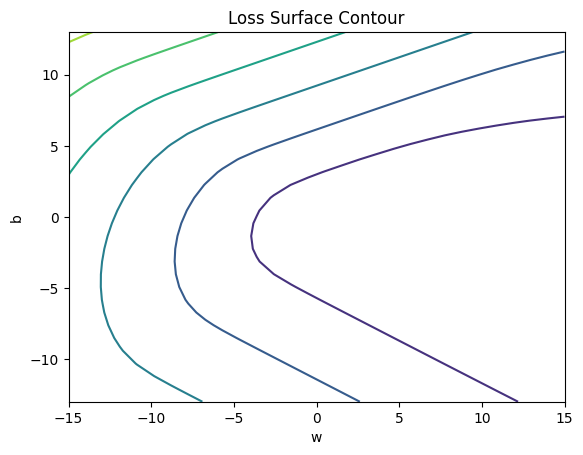

In [99]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

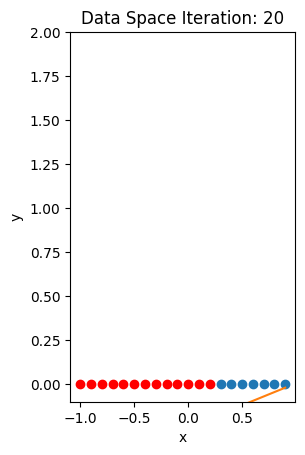

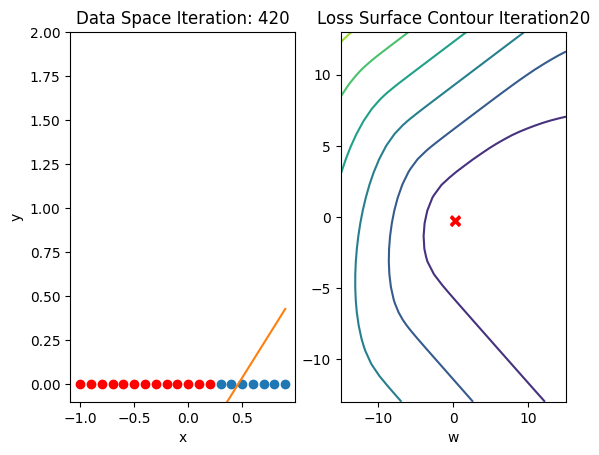

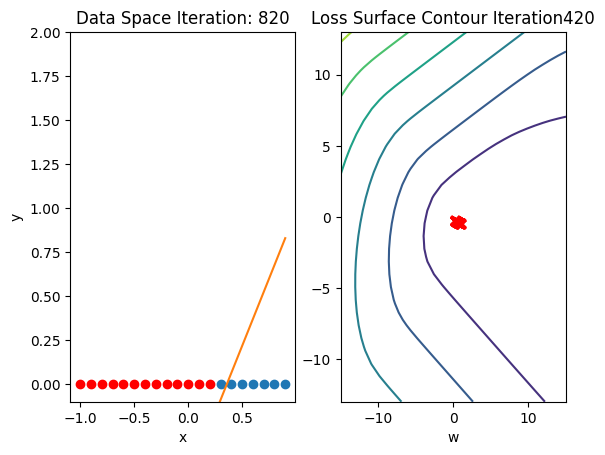

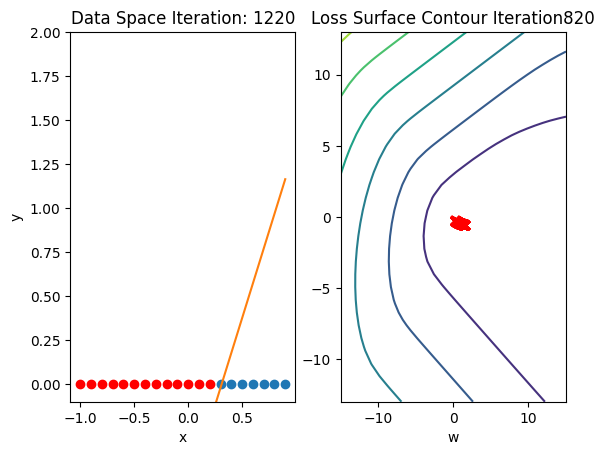

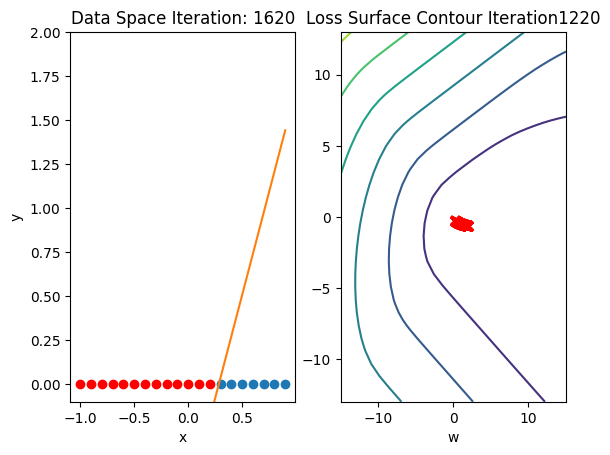

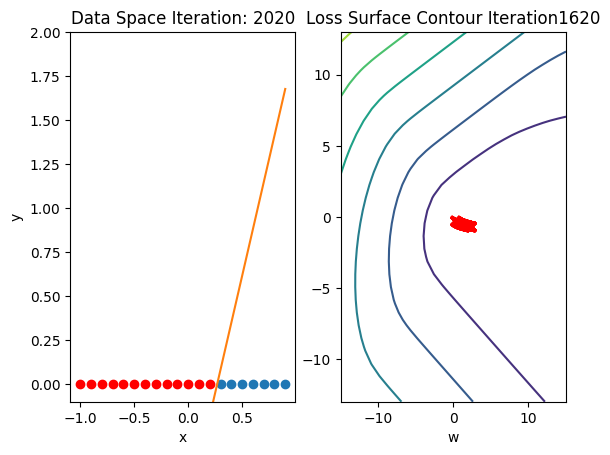

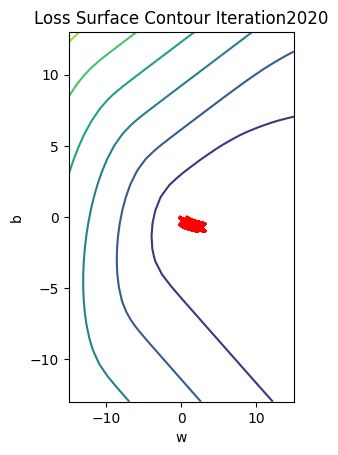

In [100]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs= 120
# This will store the loss over iterations so we can plot it at the end
loss_values = []
# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [101]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.9210]) b =  tensor(-0.7596)


In [102]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %
